# Import Libraries

In [104]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import pyarrow.parquet as pq
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

# Load the preprocessed data


In [105]:
data_dir = Path("../../data/processed")  
files = {
    "DF": data_dir / "players_data_DF_normalized.parquet",
    "FW": data_dir / "players_data_FW_normalized.parquet",
    "GK": data_dir / "players_data_GK_normalized.parquet",
    "MF": data_dir / "players_data_MF_normalized.parquet",
}

def load_clean(path):
    table = pq.read_table(path)
    table = table.replace_schema_metadata(None)
    return table.to_pandas()

df_fw = load_clean(files["FW"])
df_df = load_clean(files["DF"])
df_gk = load_clean(files["GK"])
df_mf = load_clean(files["MF"])



# Cluster Forwards 

In [106]:
print("FW shape:", df_fw.shape)
df_fw.head()
df_fw.info()
df_fw.describe()
df_fw.select_dtypes(include="object").columns


# drop_cols = ["__index_level_0__"] + ['Player', 'Nation', 'Pos', 'Squad', 'Comp', 'foot']
categorical_cols = ['Rk','Player', 'Nation', 'Pos','Squad', 'Comp', 'Age','Born','MP','Starts','Min','90s',
                    'numeric_wage', 'foot', 'W', 'D', 'L']
fw_features = df_fw.drop(columns=categorical_cols, errors="ignore")



# Print the shape and preview of the numeric dataset
print("Numeric dataset shape:", fw_features.shape)
fw_features.head()

# Handle missing values by imputing with the mean
imputer = SimpleImputer(strategy="mean")
fw_imputed = imputer.fit_transform(fw_features)

# # Standardize the features
# scaler = StandardScaler()
# fw_scaled = scaler.fit_transform(fw_imputed)

fw_scaled = fw_imputed  # Data is already normalized


# Apply PCA to reduce dimensions to 2D for plotting and visualization
pca = PCA(n_components=2, random_state=42)
fw_pca = pca.fit_transform(fw_scaled)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42, algorithm='elkan')
fw_clusters = kmeans.fit_predict(fw_pca)

# Add cluster labels to the original dataframe for easy reference
df_fw["cluster"] = fw_clusters



FW shape: (464, 126)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 464 entries, 0 to 463
Columns: 126 entries, Rk to exposure_score
dtypes: float64(116), int64(4), object(6)
memory usage: 456.9+ KB
Numeric dataset shape: (464, 112)


### Plot and List

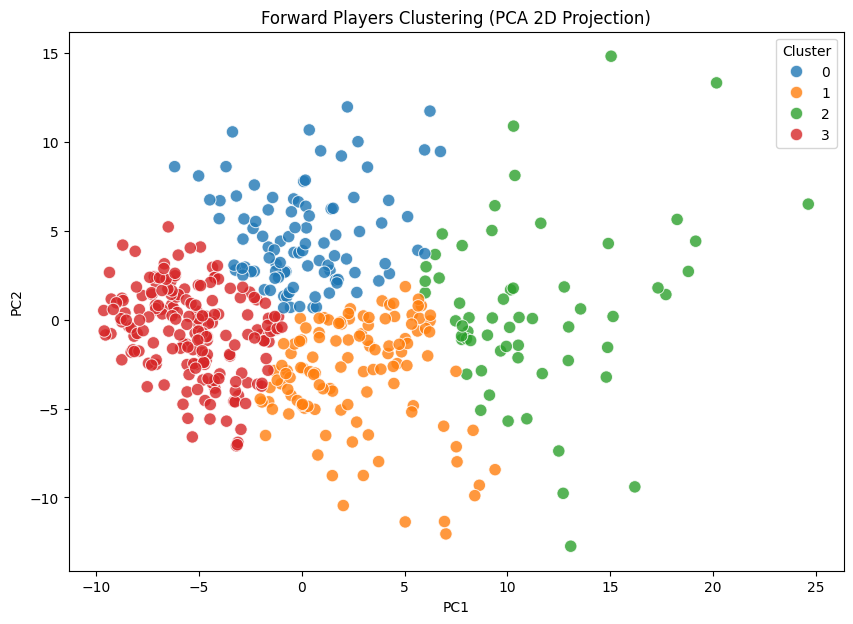

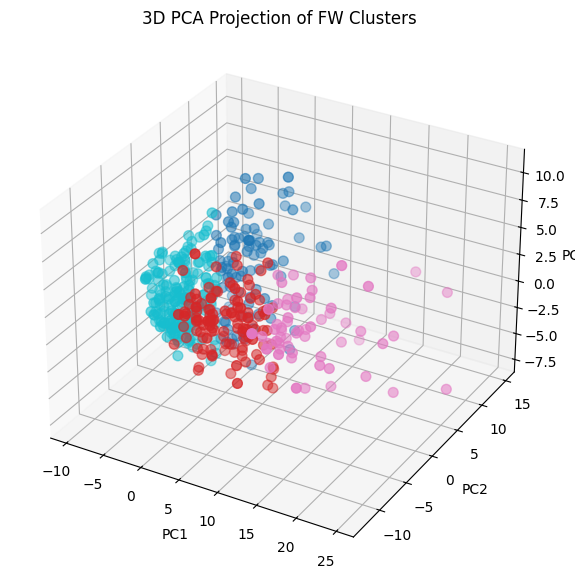

Eigenvalues (variance explained by each PC): [36.74796924 16.42020553  9.24214873]
Explained variance ratio: [0.33457829 0.14950062 0.08414675]
Cumulative variance explained: [0.33457829 0.48407891 0.56822567]


In [107]:
plt.figure(figsize=(10,7))
sns.scatterplot(
    x=fw_pca[:,0], 
    y=fw_pca[:,1], 
    hue=df_fw["cluster"],       
    palette="tab10", 
    s=80,
    alpha=0.8
)



plt.title("Forward Players Clustering (PCA 2D Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.show()



# Fit PCA for 3 components
pca_3d = PCA(n_components=3, random_state=42)
fw_pca_3d = pca_3d.fit_transform(fw_scaled)

# 3D scatter plot
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    fw_pca_3d[:,0], fw_pca_3d[:,1], fw_pca_3d[:,2], 
    c=df_fw["cluster"], cmap="tab10", s=50
)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.title("3D PCA Projection of FW Clusters")
plt.show()

# Print eigenvalues / explained variance
print("Eigenvalues (variance explained by each PC):", pca_3d.explained_variance_)
print("Explained variance ratio:", pca_3d.explained_variance_ratio_)
print("Cumulative variance explained:", np.cumsum(pca_3d.explained_variance_ratio_))


In [108]:
df_fw.head()

cluster_0_players = df_fw[df_fw["cluster"] == 1][["Player", "Squad", "Pos", "cluster"]]
print(f"Players in cluster 0: {len(cluster_0_players)}")
cluster_0_players




Players in cluster 0: 118


,Player,Squad,Pos,cluster
16,Domingos André Ribeiro Almeida,Valencia,"MF,FW",1
23,Antony,Betis,FW,1
27,Hákon Arnar Haraldsson,Lille,"MF,FW",1
29,Iago Aspas,Celta Vigo,"FW,MF",1
30,Yaser Asprilla,Girona,"FW,MF",1
...,...,...,...,...
438,Timothy Weah,Juventus,"DF,FW",1
442,Nico Williams,Athletic Club,FW,1
445,Patrick Wimmer,Wolfsburg,"MF,FW",1
459,Bryan Zaragoza,Osasuna,"FW,MF",1


### Evaluate

In [109]:

sil_score = silhouette_score(fw_scaled, df_fw["cluster"])
print("Silhouette Score:", sil_score)


dbi = davies_bouldin_score(fw_scaled, df_fw["cluster"])
print("Davies-Bouldin Index:", dbi)

ch_score = calinski_harabasz_score(fw_scaled, df_fw["cluster"])
print("Calinski-Harabasz Score:", ch_score)

# After fitting PCA
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)],
    index=fw_features.columns
)

# Sort features by importance for PC1 and PC2
loadings_PC1 = loadings["PC1"].abs().sort_values(ascending=False)
loadings_PC2 = loadings["PC2"].abs().sort_values(ascending=False)

print("Top PC1 drivers:\n", loadings_PC1.head(15))
print("\nTop PC2 drivers:\n", loadings_PC2.head(15))

low_variance = fw_features.var().sort_values().head(50)
print(low_variance)

Silhouette Score: 0.13000817573037354
Davies-Bouldin Index: 2.026031944569511
Calinski-Harabasz Score: 79.42856718426414
Top PC1 drivers:
 Carries                     0.157019
Rec                         0.156349
Touches                     0.156173
Live_stats_possession       0.156112
Att 3rd_stats_possession    0.154854
SCA                         0.153778
PassLive                    0.151238
Live                        0.149117
Att                         0.148291
TotDist_stats_possession    0.146700
KP                          0.144595
Cmp                         0.142717
PrgDist_stats_possession    0.141269
PrgP                        0.141127
PPA                         0.140644
Name: PC1, dtype: float64

Top PC2 drivers:
 xG+xAG                      0.200939
npxG                        0.198415
SoT/90                      0.196702
xG                          0.195912
G+A-PK                      0.183146
Sh/90                       0.181389
SoT                         0.179585
np

# Clustering Forwards (Feature Selection with PC1 and PC2)

## Feature Selection

Selected features for clustering:
 ['SoT', 'xG', 'Rec', 'G+A-PK', 'G-PK', 'SCA', 'Live_stats_possession', 'PassLive', 'Touches', 'Att', 'PPA', 'xAG', 'PrgDist_stats_possession', 'KP', 'npxG', 'xA', 'G+A', 'onxG', 'Carries', 'npxG+xAG', 'SoT/90', '1/3_stats_possession', 'TotDist_stats_possession', 'TotDist', 'Sh/90', 'Att 3rd_stats_possession', 'Live', 'PrgP', 'xG+xAG', 'Cmp']
K=4: Silhouette Score = 0.2789
Davies-Bouldin Index: 1.1460056162505827
Calinski-Harabasz Score: 233.59980378826543


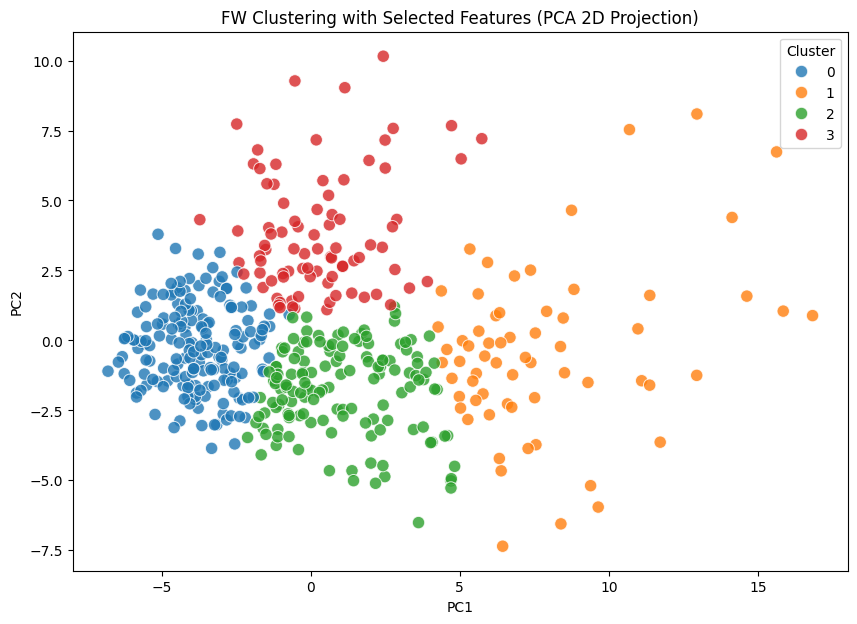

Players in cluster 0: 176


,Player,Squad,Pos,cluster
3,Tammy Abraham,Milan,FW,0
4,Akor Adams,Montpellier,FW,0
6,Junior Adamu,Freiburg,FW,0
8,Simon Adingra,Brighton,"FW,MF",0
9,Oladapo Afolayan,St. Pauli,"FW,MF",0
...,...,...,...,...
455,Bertuğ Yıldırım,Getafe,FW,0
458,Alessandro Zanoli,Genoa,"FW,DF",0
461,Joshua Zirkzee,Manchester Utd,"FW,MF",0
462,Budu Zivzivadze,Heidenheim,FW,0


Players in cluster 1: 64


,Player,Squad,Pos,cluster
0,Himad Abdelli,Angers,"MF,FW",1
11,Maghnes Akliouche,Monaco,"FW,MF",1
19,Julián Álvarez,Atlético Madrid,FW,1
35,Alex Baena,Villarreal,"MF,FW",1
39,Bradley Barcola,Paris S-G,FW,1
...,...,...,...,...
441,Iñaki Williams,Athletic Club,FW,1
447,Florian Wirtz,Leverkusen,"MF,FW",1
453,Lamine Yamal,Barcelona,FW,1
456,Kenan Yıldız,Juventus,"FW,MF",1


➡️ Alexander Isak:

🔹 Predicted Cluster: 3

Showing 10 players most similar (same cluster):


,Player,Squad,Pos
1,Matthis Abline,Nantes,FW
2,Zakaria Aboukhlal,Toulouse,"MF,FW"
5,Che Adams,Torino,FW
7,Karim Adeyemi,Dortmund,"FW,MF"
10,Ludovic Ajorque,Brest,FW
40,Harvey Barnes,Newcastle Utd,FW
42,Thierno Barry,Villarreal,FW
44,Maximilian Beier,Dortmund,"FW,MF"
51,Mika Biereth,Monaco,FW
57,Victor Boniface,Leverkusen,FW



➡️ Nick Woltemade:

🔹 Predicted Cluster: 3

Showing 10 players most similar (same cluster):


,Player,Squad,Pos
1,Matthis Abline,Nantes,FW
2,Zakaria Aboukhlal,Toulouse,"MF,FW"
5,Che Adams,Torino,FW
7,Karim Adeyemi,Dortmund,"FW,MF"
10,Ludovic Ajorque,Brest,FW
40,Harvey Barnes,Newcastle Utd,FW
42,Thierno Barry,Villarreal,FW
44,Maximilian Beier,Dortmund,"FW,MF"
51,Mika Biereth,Monaco,FW
57,Victor Boniface,Leverkusen,FW


In [ ]:
# Drop features with low variance and select top features from PC1 and PC2
selected_features = list(loadings_PC1.head(20).index) + list(loadings_PC2.head(10).index)
selected_features = list(set(selected_features))  # Remove duplicates
print("Selected features for clustering:\n", selected_features)



fw_sel = df_fw[selected_features].copy()
# Make Nan values 0
fw_sel = fw_sel.fillna(0)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
fw_scaled_sel = scaler.fit_transform(fw_sel)

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


km = KMeans(n_clusters=4, random_state=42)
clusters = km.fit_predict(fw_scaled_sel)
sil = silhouette_score(fw_scaled_sel, clusters)
print(f"K=4: Silhouette Score = {sil:.4f}")

# Evaluate
dbi = davies_bouldin_score(fw_scaled_sel, clusters)
print("Davies-Bouldin Index:", dbi)

ch_score = calinski_harabasz_score(fw_scaled_sel, clusters)
print("Calinski-Harabasz Score:", ch_score)

# Add cluster labels to the original dataframe for easy reference
df_fw["cluster"] = clusters

# Plotting with selected features
pca_sel = PCA(n_components=2, random_state=42)
fw_pca_sel = pca_sel.fit_transform(fw_scaled_sel)
plt.figure(figsize=(10,7))
sns.scatterplot(
    x=fw_pca_sel[:,0], 
    y=fw_pca_sel[:,1], 
    hue=clusters,       
    palette="tab10", 
    s=80,
    alpha=0.8
)
plt.title("FW Clustering with Selected Features (PCA 2D Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.show()

# List players from cluster 1

cluster_0_players = df_fw[df_fw["cluster"] == 0][["Player", "Squad", "Pos", "cluster"]]
cluster_1_players = df_fw[df_fw["cluster"] == 1][["Player", "Squad", "Pos", "cluster"]]

# print(f"Players in cluster 0: {len(cluster_0_players)}")
# cluster_0_players

# cluster_1_players = fw_sel[np.array(clusters) == 1]
# print(f"Players in cluster 1: {len(cluster_1_players)}")
# cluster_1_players

print(f"Players in cluster 0: {len(cluster_0_players)}")
display(cluster_0_players)
print(f"Players in cluster 1: {len(cluster_1_players)}")
display(cluster_1_players)





